<a href="https://colab.research.google.com/github/bindumanoj8480-cyber/MLOPS-ASSIGNMENT1/blob/main/Another_copy_of_Untitled236.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import time
import joblib
import argparse
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List
!pip install ucimlrepo mlflow
from ucimlrepo import fetch_ucirepo

# MLflow
import mlflow
from mlflow.models.signature import infer_signature

# Sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
)

# FastAPI
from fastapi import FastAPI, Response
from pydantic import BaseModel
import uvicorn

# Prometheus metrics
from prometheus_client import Counter, Histogram, generate_latest, CONTENT_TYPE_LATEST, CollectorRegistry


# -----------------------------
# Configuration and constants
# -----------------------------

CATEGORICAL_COLS: List[str] = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal", "ca"]
NUMERIC_COLS: List[str] = ["age", "trestbps", "chol", "thalach", "oldpeak"]
TARGET_COL: str = "num"  # UCI Heart Disease 'num' (0..4). We'll binarize to 0/1.

SCORERS = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "roc_auc": make_scorer(roc_auc_score),
}

FEATURE_ORDER = [
    "age","sex","cp","trestbps","chol","fbs","restecg",
    "thalach","exang","oldpeak","slope","ca","thal"
]

EXPERIMENT_NAME = "heart_disease_classification"
EDA_DIR = "data"
FINAL_MODEL_PATH = os.path.join(EDA_DIR, "final_model.pkl")
FINAL_CHOICE_PATH = os.path.join(EDA_DIR, "final_choice.json")


# -----------------------------
# Data loading and cleaning
# -----------------------------

def load_uci_heart() -> pd.DataFrame:
    heart = fetch_ucirepo(id=45)
    X = heart.data.features.copy()
    y = heart.data.targets.copy()
    df = pd.concat([X, y], axis=1)
    return df


def clean_heart(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

    if TARGET_COL not in df.columns:
        raise ValueError(f"Target column '{TARGET_COL}' not found in dataset.")

    df[TARGET_COL] = (df[TARGET_COL] > 0).astype(int)
    df = df.replace("?", np.nan)

    # coerce numeric
    for col in NUMERIC_COLS + ["ca"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # impute
    for col in df.columns:
        if col == TARGET_COL:
            continue
        if df[col].dtype.kind in "biufc":
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode().iloc[0])
    return df


def split_X_y(df: pd.DataFrame):
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL]
    return X, y


# -----------------------------
# EDA visualizations
# -----------------------------

def plot_histograms(df: pd.DataFrame, numeric_cols: List[str], out_path: str):
    plt.figure(figsize=(12, 8))
    df[numeric_cols].hist(bins=20, figsize=(12, 8))
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


def plot_correlation_heatmap(df: pd.DataFrame, numeric_cols: List[str], out_path: str):
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


def plot_class_balance(y: pd.Series, out_path: str):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title("Class Balance (0: no disease, 1: disease)")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


# -----------------------------
# Feature preprocessing
# -----------------------------

def build_preprocessing() -> ColumnTransformer:
    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, NUMERIC_COLS),
            ("cat", categorical_transformer, CATEGORICAL_COLS),
        ],
        remainder="drop"
    )
    return preprocessor


# -----------------------------
# Models, tuning, evaluation
# -----------------------------

def build_logreg_pipeline() -> Pipeline:
    preprocessor = build_preprocessing()
    clf = LogisticRegression(max_iter=200, solver="liblinear", class_weight="balanced")
    pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
    return pipe


def build_rf_pipeline() -> Pipeline:
    preprocessor = build_preprocessing()
    clf = RandomForestClassifier(
        n_estimators=200, max_depth=None, n_jobs=-1, class_weight="balanced_subsample", random_state=42
    )
    pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
    return pipe


def tune_logreg(X, y) -> GridSearchCV:
    pipe = build_logreg_pipeline()
    param_grid = {
        "clf__C": [0.1, 1.0, 10.0],
        "clf__penalty": ["l1", "l2"],
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1)
    grid.fit(X, y)
    return grid


def tune_rf(X, y) -> GridSearchCV:
    pipe = build_rf_pipeline()
    param_grid = {
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [None, 8, 16],
        "clf__min_samples_split": [2, 5],
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=cv, n_jobs=-1)
    grid.fit(X, y)
    return grid


def evaluate_cv(pipe: Pipeline, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(pipe, X, y, cv=cv, scoring=SCORERS, return_train_score=False)
    return {k: float(np.mean(v)) for k, v in results.items() if "test_" in k}


# -----------------------------
# MLflow helpers
# -----------------------------

def init_mlflow(experiment_name=EXPERIMENT_NAME, tracking_uri=None):
    if tracking_uri:
        mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(experiment_name)


def log_model_with_signature(model, X_sample, model_name="model"):
    try:
        outputs = model.predict_proba(X_sample) if hasattr(model, "predict_proba") else model.predict(X_sample)
        signature = infer_signature(X_sample, outputs)
        mlflow.sklearn.log_model(model, artifact_path=model_name, signature=signature)
    except Exception:
        mlflow.sklearn.log_model(model, artifact_path=model_name)


# -----------------------------
# Training entrypoint
# -----------------------------

def run_training():
    os.makedirs(EDA_DIR, exist_ok=True)
    init_mlflow(EXPERIMENT_NAME)

    df = load_uci_heart()
    df = clean_heart(df)
    X, y = split_X_y(df)

    # EDA artifacts
    hist_path = os.path.join(EDA_DIR, "histograms.png")
    corr_path = os.path.join(EDA_DIR, "corr_heatmap.png")
    class_path = os.path.join(EDA_DIR, "class_balance.png")

    plot_histograms(df, NUMERIC_COLS, out_path=hist_path)
    plot_correlation_heatmap(df, NUMERIC_COLS, out_path=corr_path)
    plot_class_balance(y, out_path=class_path)

    # Baselines
    with mlflow.start_run(run_name="baseline_logreg"):
        pipe_lr = build_logreg_pipeline()
        metrics_lr = evaluate_cv(pipe_lr, X, y)
        mlflow.log_params({"model": "logreg_baseline"})
        mlflow.log_metrics({k.replace("test_", ""): v for k, v in metrics_lr.items()})
        mlflow.log_artifact(hist_path)
        mlflow.log_artifact(corr_path)
        mlflow.log_artifact(class_path)

    with mlflow.start_run(run_name="baseline_rf"):
        pipe_rf = build_rf_pipeline()
        metrics_rf = evaluate_cv(pipe_rf, X, y)
        mlflow.log_params({"model": "rf_baseline"})
        mlflow.log_metrics({k.replace("test_", ""): v for k, v in metrics_rf.items()})

    # Tuning
    with mlflow.start_run(run_name="tuned_logreg"):
        grid_lr = tune_logreg(X, y)
        best_lr = grid_lr.best_estimator_
        mlflow.log_params({"model": "logreg_tuned", **grid_lr.best_params_})
        metrics_lr_tuned = evaluate_cv(best_lr, X, y)
        mlflow.log_metrics({k.replace("test_", ""): v for k, v in metrics_lr_tuned.items()})
        log_model_with_signature(best_lr, X.iloc[:10], "model")

    with mlflow.start_run(run_name="tuned_rf"):
        grid_rf = tune_rf(X, y)
        best_rf = grid_rf.best_estimator_
        mlflow.log_params({"model": "rf_tuned", **grid_rf.best_params_})
        metrics_rf_tuned = evaluate_cv(best_rf, X, y)
        mlflow.log_metrics({k.replace("test_", ""): v for k, v in metrics_rf_tuned.items()})
        log_model_with_signature(best_rf, X.iloc[:10], "model")

    # Choose final based on ROC-AUC
    auc_lr = metrics_lr_tuned["test_roc_auc"]
    auc_rf = metrics_rf_tuned["test_roc_auc"]
    final_model = best_rf if auc_rf >= auc_lr else best_lr
    choice = "rf" if final_model is best_rf else "logreg"
    with open(FINAL_CHOICE_PATH, "w") as f:
        json.dump({"final_model": choice, "roc_auc": {"rf": auc_rf, "logreg": auc_lr}}, f)

    joblib.dump(final_model, FINAL_MODEL_PATH)
    print(f"Training complete. Final model: {choice}. Saved to {FINAL_MODEL_PATH}")


# -----------------------------
# Serving API (FastAPI)
# -----------------------------

class HeartInput(BaseModel):
    age: float
    sex: int
    cp: int
    trestbps: float
    chol: float
    fbs: int
    restecg: int
    thalach: float
    exang: int
    oldpeak: float
    slope: int
    ca: float
    thal: int


class PredictResponse(BaseModel):
    prediction: int
    confidence: float
    latency_ms: float

# Create a specific registry for these metrics
metrics_registry = CollectorRegistry()
REQUEST_COUNT = Counter("requests_total", "Total API requests", ["endpoint", "method", "status"], registry=metrics_registry)
LATENCY = Histogram("request_latency_ms", "Request latency in ms", buckets=[10,50,100,200,500,1000], registry=metrics_registry)

def create_app(model_path: str) -> FastAPI:
    logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
    logger = logging.getLogger("api")

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")

    model = joblib.load(model_path)
    app = FastAPI(title="Heart Disease Classifier API")

    @app.get("/metrics")
    def metrics():
        return Response(generate_latest(registry=metrics_registry), media_type=CONTENT_TYPE_LATEST)

    @app.post("/predict", response_model=PredictResponse)
    def predict(input: HeartInput):
        start = time.time()
        x = np.array([[getattr(input, f) for f in FEATURE_ORDER]])
        if hasattr(model, "predict_proba"):
            proba = float(model.predict_proba(x)[0, 1])
        else:
            # Fallback (rare): use decision_function or predict
            try:
                proba = float(model.decision_function(x))
            except Exception:
                proba = float(model.predict(x)[0])
        pred = int(proba >= 0.5)
        latency = (time.time() - start) * 1000
        LATENCY.observe(latency)
        REQUEST_COUNT.labels(endpoint="/predict", method="POST", status="200").inc()
        logger.info(f"predict request: pred={pred} proba={proba:.4f} latency_ms={latency:.2f}")
        return PredictResponse(prediction=pred, confidence=proba, latency_ms=latency)

    return app


# -----------------------------
# CLI entrypoint
# -----------------------------

def parse_args():
    parser = argparse.ArgumentParser(description="Heart Disease ML pipeline and API (single-file).")
    parser.add_argument("--mode", choices=["train", "serve"], required=True, help="Run training or serve API.")
    parser.add_argument("--model_path", default=FINAL_MODEL_PATH, help="Path to saved model (for serving).")
    parser.add_argument("--host", default="0.0.0.0", help="API host (serve mode).")
    parser.add_argument("--port", type=int, default=8000, help="API port (serve mode).")
    return parser.parse_args()


def main():
    args = parse_args()
    if args.mode == "train":
        run_training()
        print("Tip: launch MLflow UI with: mlflow ui --port 5000")
    elif args.mode == "serve":
        app = create_app(args.model_path)
        uvicorn.run(app, host=args.host, port=args.port)


if __name__ == "__main__":
    # main() # Commented out the call to main() to prevent argparse error in notebook
    run_training() # Directly call run_training for notebook execution
    print("Training completed. You can now explore the MLflow UI by running `!mlflow ui --port 5000` in a new cell.")


2025/12/08 12:10:20 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/08 12:10:20 INFO mlflow.store.db.utils: Updating database tables
2025/12/08 12:10:20 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/08 12:10:20 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/08 12:10:20 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2025/12/08 12:10:20 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2025/12/08 12:10:20 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2025/12/08 12:10:20 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2025/12/08 12:10:20 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2025/12/08 12:10:21 INFO alembic.runtime.migration: Running 

Training complete. Final model: logreg. Saved to data/final_model.pkl
Training completed. You can now explore the MLflow UI by running `!mlflow ui --port 5000` in a new cell.


<Figure size 1200x800 with 0 Axes>

In [ ]:
X, y = split_X_y(df_cleaned)
class_balance_path = os.path.join(EDA_DIR, "class_balance.png")
plot_class_balance(y, out_path=class_balance_path)
print(f"Class balance plot saved to: {class_balance_path}")

Class balance plot saved to: data/class_balance.png


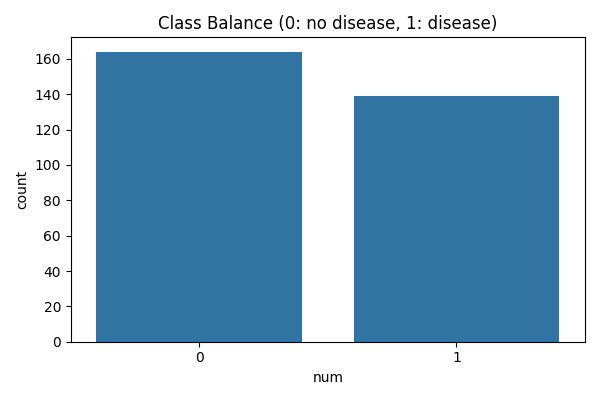

In [ ]:
from IPython.display import Image
class_balance_path = os.path.join(EDA_DIR, "class_balance.png")
Image(filename=class_balance_path)

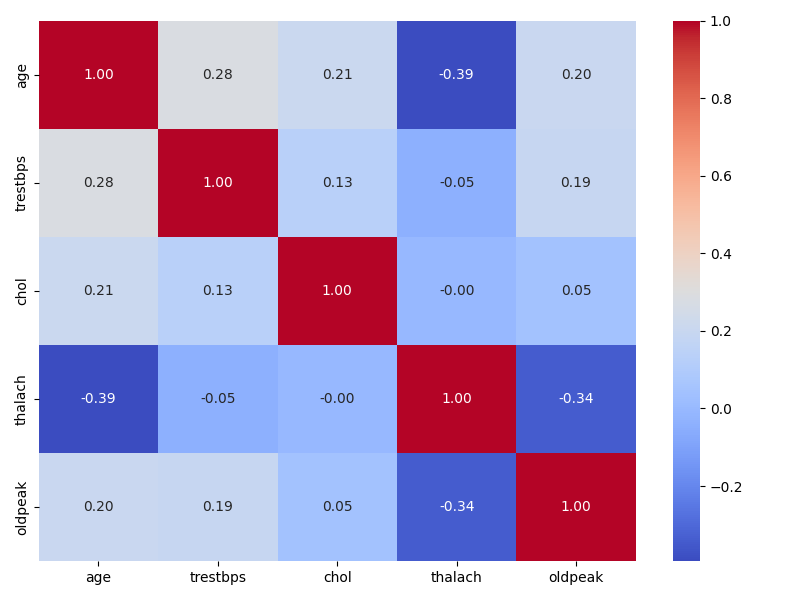

In [ ]:
from IPython.display import Image
corr_path = os.path.join(EDA_DIR, "corr_heatmap_cleaned.png")
Image(filename=corr_path)

In [ ]:
corr_path = os.path.join(EDA_DIR, "corr_heatmap_cleaned.png")
plot_correlation_heatmap(df_cleaned, NUMERIC_COLS, out_path=corr_path)
print(f"Correlation heatmap saved to: {corr_path}")

Correlation heatmap saved to: data/corr_heatmap_cleaned.png


In [ ]:
display(df_cleaned.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,3.158416,0.960126,1.0,3.0,3.0,4.0,4.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [ ]:
df = load_uci_heart()
df_cleaned = clean_heart(df)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [ ]:
import mlflow
import pandas as pd

client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# Search for the run named 'tuned_rf'
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.mlflow.runName = 'tuned_rf'",
    order_by=["start_time DESC"],
    max_results=1
)

if not runs.empty:
    run_id = runs.iloc[0].run_id
    metrics = client.get_run(run_id).data.metrics
    print("Metrics for the final Random Forest model:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
else:
    print("Could not find the 'tuned_rf' run in MLflow.")

Metrics for the final Random Forest model:
  accuracy: 0.8319
  precision: 0.8421
  recall: 0.7844
  roc_auc: 0.8284
